In [35]:
import skimage
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from math import floor
import datetime
from torchvision import transforms

from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch
from scipy.ndimage import gaussian_filter
import cv2 as cv

%matplotlib inline


In [2]:
def compute_voronoi_sites(input_img):
    sites = []
    
    uintimage = input_img.copy()

    # Flip the colours of the image
    uintimage[uintimage == 255] = 2
    uintimage[uintimage == 0] = 255
    uintimage[uintimage == 2] = 0
    
    # Find the contours of the image
    contours, hierarchies = cv.findContours(
        uintimage, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    
    # Calculate each of the centers of the image
    for contour in contours:
        M = cv.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            sites.append([cX, cY])
            
    return sites

def transform_img(img, permute = (1,2,0)):
    
    img = img.permute(*permute)
    return img

def show_image(img, title = "No title", alpha = 1):
    img = transform_img(img)
    
    plt.axis('off')
    plt.imshow(img, cmap='gray', alpha = alpha)
    plt.title(title)

def extract_sites_coordinates(segmentation, index):
    return list(zip(*np.where(segmentation[index][0] == 1)))

def normalise(x):
    min_val = torch.min(x)
    max_val = torch.max(x)

    # normalize the tensor
    return (x - min_val) / (max_val - min_val)

In [3]:
class VoronoiZSlice():
    path = './segmentation_and_background_composite.tif'
    
     
    def __init__(self, img_size = (128,128), time_step=[0], l = 850, r = 6500, t = 0):
        self.object = skimage.io.imread(self.path)
        self.time_step = time_step
        
        self.l = l
        self.r = r
        self.t = t
        self.img_size = img_size
        
        self.images_horizontally = (r - l) // img_size[1]
        self.subimages_in_image = self.images_horizontally * (2560 // img_size[0])
        
        print(f"Loading object with shape: {self.object.shape}")
    
    def __len__(self):
        return len(self.time_step) * self.subimages_in_image

    def __getitem__(self, idx):
        specific_image = self.time_step[idx // self.subimages_in_image]
        idx_in_img = idx % self.subimages_in_image

        horiz = self.l + (self.img_size[0] * ((idx_in_img) % self.images_horizontally))
        vert = self.t + (self.img_size[1] * floor((idx_in_img) / self.images_horizontally))
        
        segmentation = self.object[specific_image][0][vert: vert + self.img_size[1], horiz: horiz + self.img_size[0]]
        cellular_image = self.object[specific_image][1][vert: vert + self.img_size[1], horiz: horiz + self.img_size[0]]
        
        segmentation_voronoi_sites = compute_voronoi_sites(segmentation)
        segmentation_voronoi = torch.zeros(1,*self.img_size)
        
        for site in segmentation_voronoi_sites:
            segmentation_voronoi[0, site[1], site[0]] = 1

        return segmentation_voronoi, transforms.ToTensor()(segmentation), transforms.ToTensor()(cellular_image)

In [4]:
train = DataLoader(VoronoiZSlice(time_step = [0], l = 650, r = 6500), batch_size = 32, shuffle=True)
val = DataLoader(VoronoiZSlice(time_step = [195],  l = 650, r = 6500), batch_size = 32, shuffle=True)

Loading object with shape: (200, 2, 2560, 7210)
Loading object with shape: (200, 2, 2560, 7210)


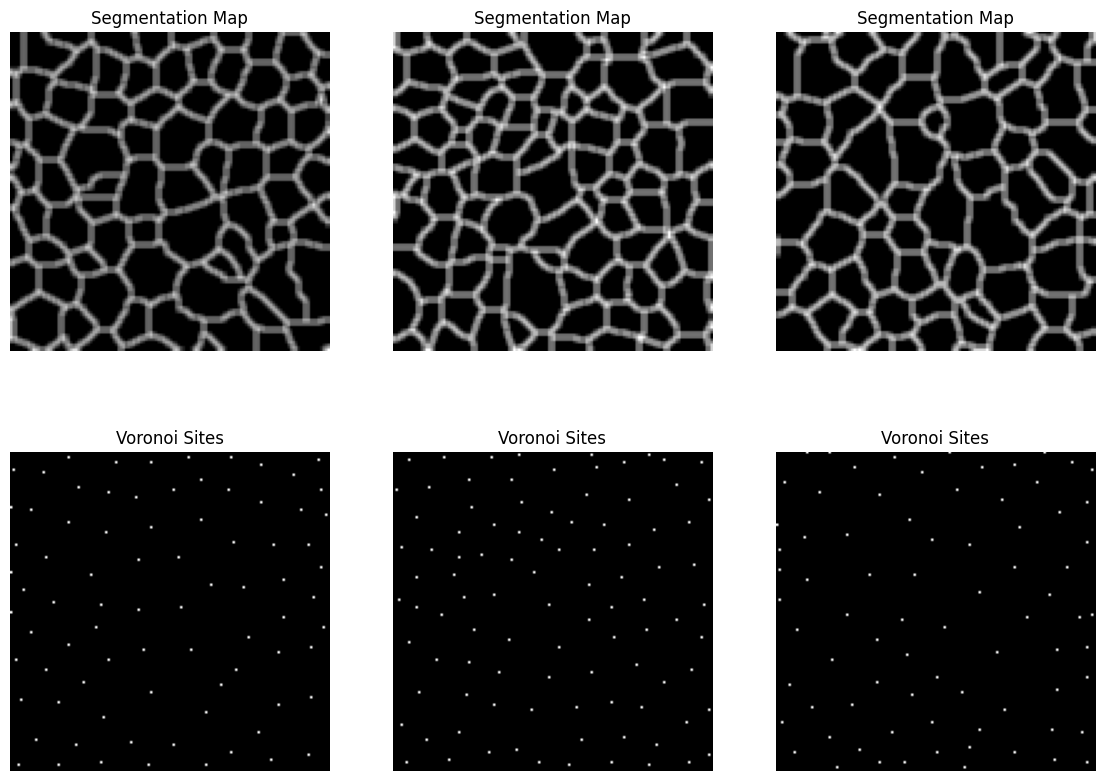

In [24]:
n_samples = 3
img, tar, _ = next(iter(train))

# tar = transforms.GaussianBlur((3,3))(tar)
tar = transforms.GaussianBlur(kernel_size = 3, sigma = 3)(tar)

plt.figure(figsize=(14,10))
for i in range(n_samples):
    a, b = img[i], tar[i]

    plt.subplot(2, n_samples, 1 + i)
    show_image(b, "Segmentation Map")
    
    plt.subplot(2, n_samples, 1 + n_samples + i)
    show_image(a, "Voronoi Sites")

plt.show()

In [9]:
class UNet(nn.Module):
    
    def __init__(self, channels = 1):
        # Input Size: 1 x 128 x 128
        super().__init__()
        
        self.d1 = nn.Conv2d(channels, 64, 4, 2, 1);
        # Size: 64 x 64 x 64
        
        self.d2 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128)
        )
        # Size: 128 x 32 x 32
        
        self.d3 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256)
        )
        # Size: 256 x 16 x 16
        
        self.d4 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512)
        )
        # Size: 512 x 8 x 8
        
        self.d5 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512)
        )
        # Size: 512 x 4 x 4
        
        self.d6 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(512, 512, 4, 2, 1),
        )
        
        # Size: 512 x 2 x 2
        
        self.u1 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride = 2, padding=1),
            nn.BatchNorm2d(512),
        )
        # Size: 512 x 4 x 4
        
        self.u2 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512 * 2, 512, kernel_size=4, stride = 2, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5)
        )
        
        # Size: 512 x 8 x 8
        self.u3 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(512 * 2, 256, kernel_size=4, stride = 2, padding=1),
            nn.BatchNorm2d(256)
        )
        
        # Size: 256 x 16 x 16
        self.u4 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(256 * 2, 128, kernel_size=4, stride = 2, padding=1),
            nn.BatchNorm2d(128)
        )
        # Size: 128 x 32 x 32
        
        self.u5 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(128 * 2, 64, kernel_size=4, stride = 2, padding=1),
            nn.BatchNorm2d(64)
        )
        
        # Size: 64 x 64 x 64
        
        self.u6 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64 * 2, 1, kernel_size=4, stride = 2, padding=1),
            nn.Tanh()
        )
        
        # Size: 1 x 128 x 128
    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        d5 = self.d5(d4)
        
        latent_space = self.d6(d5)
        
        u1 = torch.cat((self.u1(latent_space), d5), dim=1)
        u2 = torch.cat((self.u2(u1), d4), dim=1)
        u3 = torch.cat((self.u3(u2), d3), dim=1)
        u4 = torch.cat((self.u4(u3), d2), dim=1)
        u5 = torch.cat((self.u5(u4), d1), dim=1)
    
        return self.u6(u5)
    

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, input_channels = 1):
        super().__init__()
        # Size: 2 x 128 x 128 (two images are stacked on each other)
        
        self.model = nn.Sequential(
            nn.Conv2d(input_channels * 2, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Size: 64 x 64 x 64
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            
            # Size: 128 x 32 x 32
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            
            # Size: 256 x 16 x 16
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            
            # Size: 512 x 8 x 8
            nn.Conv2d(512, 1, 4, 2, 1, bias=False),      
            nn.Sigmoid()
        )
        
    def forward(self, imgA, imgB):
        img = torch.cat((imgA, imgB), dim=1)
        return self.model(img)

In [15]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [47]:
torch.manual_seed(0)

L_gan = nn.BCELoss()
L_l1 = nn.L1Loss()
lambda_pixel = 100
epochs = 100

generator = UNet()
discriminator = Discriminator()

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

optim_G = torch.optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))

Tensor = torch.FloatTensor

generator.to(torch.device("mps"))
discriminator.to(torch.device("mps"))
L_gan.to(torch.device("mps"))
L_l1.to(torch.device("mps"))

L1Loss()

In [48]:
i = 0

print(f"Starting training at {datetime.datetime.now()}")
for epoch in range(epochs):
    
    for img, tar, _ in train:
        tar = torch.Tensor(gaussian_filter(tar, sigma=2.5))

        img, tar = img.to(torch.device("mps")), tar.to(torch.device("mps"))

        valid = torch.ones(size = (img.size(0),1,4,4), dtype=torch.float).to(torch.device("mps"))
        fake = torch.zeros(size = (img.size(0),1,4,4), dtype=torch.float).to(torch.device("mps"))
        
        optim_D.zero_grad()
        
        # Check that the discriminator is able to predict real images with high probability
        Dx = discriminator(img, tar)
        lossD_real = 0.5 * L_gan(Dx, valid)
        lossD_real.backward()
        
        # Instead of training the discriminator on generator images, we can try and train the discriminator on more 
        # 'realistic' fake images. Idea from Bretschneider paper
        DGz = discriminator(img, transforms.GaussianBlur((3,3))(tar))
        lossD_fake = 0.5 * L_gan(DGz, fake)
        lossD_fake.backward()  
        optim_D.step()
        
        # ----
        # Train Generator
        # ----
        
        optim_G.zero_grad()
        Gz = generator(img)
        outputs = discriminator(img, Gz) 
        loss_G = L_gan(outputs, valid) + lambda_pixel * L_l1(Gz, tar)
        loss_G.backward()
        optim_G.step()
        
        if epoch % 10 == 0:
            img, tar, _ = next(iter(val))
            img, tar = img.to(torch.device("mps")), tar.to(torch.device("mps"))

            Gz = generator(img)

            img_sample = torch.cat((img, tar, Gz), -2)
            save_image(img_sample, f"voronoi_map_to_image_no-deblur_{epoch}.png", nrow=4)
        
    print(f"Epoch {epoch}/{epochs} Generator Loss: {loss_G.item():.4f} Real Loss: {lossD_real.item():.2f} Fake Loss: {lossD_fake.item():.2f} Time: {datetime.datetime.now()}") 

Starting training at 2023-11-10 17:57:13.210087
Epoch 0/100 Generator Loss: 13.1854 Real Loss: 0.47 Fake Loss: 0.43 Time: 2023-11-10 17:57:48.198388
Epoch 1/100 Generator Loss: 8.7518 Real Loss: 0.46 Fake Loss: 0.39 Time: 2023-11-10 17:58:01.473728
Epoch 2/100 Generator Loss: 6.8464 Real Loss: 0.43 Fake Loss: 0.38 Time: 2023-11-10 17:58:13.321482
Epoch 3/100 Generator Loss: 6.2471 Real Loss: 0.41 Fake Loss: 0.40 Time: 2023-11-10 17:58:25.137597
Epoch 4/100 Generator Loss: 5.4045 Real Loss: 0.42 Fake Loss: 0.35 Time: 2023-11-10 17:58:36.984070
Epoch 5/100 Generator Loss: 5.0710 Real Loss: 0.42 Fake Loss: 0.33 Time: 2023-11-10 17:58:48.894894
Epoch 6/100 Generator Loss: 5.1423 Real Loss: 0.38 Fake Loss: 0.41 Time: 2023-11-10 17:59:00.846717
Epoch 7/100 Generator Loss: 4.7451 Real Loss: 0.40 Fake Loss: 0.37 Time: 2023-11-10 17:59:12.473377
Epoch 8/100 Generator Loss: 5.0914 Real Loss: 0.37 Fake Loss: 0.41 Time: 2023-11-10 17:59:23.880243
Epoch 9/100 Generator Loss: 4.8601 Real Loss: 0.40 

KeyboardInterrupt: 

In [ ]:
torch.save(generator.state_dict(), 'temp.pth')

### Testing Area

In [ ]:
generator = UNet()
generator.load_state_dict(torch.load('/Users/siddharthsrivastava/Library/CloudStorage/OneDrive-UniversityofWarwick/Dissertation Models - Siddharth Srivastava/unet_voronoi_to_segmentation_128.pth', map_location=torch.device('cpu')))

In [ ]:
from scipy.ndimage import median_filter
from skimage.exposure import equalize_adapthist
from skimage import filters

import kornia
from scipy.spatial import Voronoi, voronoi_plot_2d

In [ ]:
sites, tar, cell = next(iter(val))

In [ ]:
s = transforms.GaussianBlur(kernel_size = (11,11))(tar)

plt.imshow(s[0][0], cmap='gray')

In [ ]:
skimage.io.imsave("/Users/siddharthsrivastava/Library/CloudStorage/OneDrive-UniversityofWarwick/Dissertation Models - Siddharth Srivastava/dataset/gan-segmentation-map_size-128-128_timestep-195.tiff", Gz1.numpy(), plugin='tifffile')

In [ ]:
Gz1 = generator(sites.to(device = 'mps')).detach().cpu()
# Gz2 = generator(seg2).detach().cpu()

In [ ]:
vor = Voronoi(sites)
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
fig = voronoi_plot_2d(vor)
fig
plt.subplot(1,2,2)
plt.imshow(seg[0][0], cmap='gray')

In [ ]:
plt.figure(figsize=(10,7))
for i in range(6):
    plt.subplot(2,3,i + 1)
    show_image(Gz1[i].cpu(), "")
    # show_image(tar[i].cpu(), "", alpha=0.4)

In [ ]:
# Try adding a local median filter to remove the dumb black spots in the image
med_filtered = normalise(torch.from_numpy(median_filter(Gz1, size=(1,1,3,3))))

In [ ]:
import tifffile
tifffile.imsave("128_128_finaltimestep_ground_truth_seg_map.tiff", tar.numpy())

In [ ]:
# Apply local contrast enhancement with CLAHE
clahe = med_filtered.clone()
for i in range(clahe.shape[0]):
    clahe[i] = torch.from_numpy(equalize_adapthist(med_filtered[i][0].numpy(), kernel_size = 8)).unsqueeze(dim=0)

In [ ]:
# Try some filtering
thresholded_after_med_filter = torch.where(clahe >= filters.threshold_otsu(clahe.numpy()), 1, 0)

# Add some dilation and thinning
dilate = kornia.morphology.dilation(thresholded_after_med_filter, torch.ones(3,3))
thinned = dilate.clone()
for i in range(dilate.shape[0]):
    thinned[i] = torch.from_numpy(skimage.morphology.skeletonize(dilate[i].squeeze().numpy()))

In [ ]:
plt.figure(figsize=(30,30))
for i in range(100):
    plt.subplot(10,10,i + 1)
    show_image(med_filtered[i], "")
    show_image(seg[i], "", alpha=0.7)
    
# plt.figure(figsize=(10,7))
# for i in range(6):
#     plt.subplot(2,3,i + 1)
#     show_image(seg[i], "")
#     show_image(tar[i], "", alpha=0.4)

In [ ]:
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(seg[0].permute(2,1,0), cmap='gray')
plt.imshow(thinned[0].permute(2,1,0), alpha=0.4, cmap='gray')

In [ ]:
stage_2_gan = UNet()
stage_2_gan.load_state_dict(torch.load('../map_to_cell_generator_300.pth'))

In [ ]:
kornia.metrics.ssim(thinned, thinned2, 11).mean()

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
show_image(dilated[0], "Dilated Image")

plt.subplot(1,2,2)
show_image(Gz1[0], "Binary Image")

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(thinned_img)

In [ ]:
res = normalise(stage_2_gan(thinned).detach())
res2 = normalise(stage_2_gan(thinned2).detach())

In [ ]:
kornia.metrics.ssim(res, cell, 11).mean()

In [ ]:
plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(2,3,i + 1)
    show_image(res[i], "")

In [ ]:
plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(2,3,i + 1)
    show_image(seg[i], "")
    show_image(res[i], "", alpha=0.6)